# Spectral Clustering 을 직접구현해보자

clustering은 EDA	에 많이 사용되는 기술로
데이터를 동일그룹은 유사한것끼리 다른그룹은 서로 차이나게 그룹을 나누는데 목적이 있다<br>
spectral clustering을 구현하는데 크게 3가지 과정이 있다<br>

1. N개의 개체들의 유사도 그래프를 만들것
2. 각 개체들의 Laplacian Matrix에서 k 번째 고유벡터를 계산
3. K-means 알고리즘을 통해서 k개의 개체들로 구분할것

### [Comparing different clustering algorithms on toy datasets](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py) 에서 dataset을 참고했습니다

In [199]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

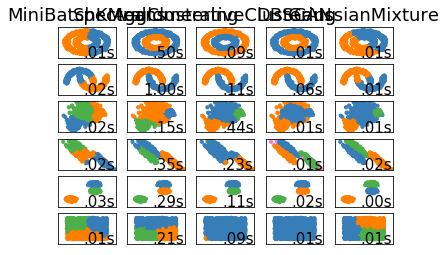

In [200]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        #('MeanShift', ms),
        ('SpectralClustering', spectral),
        #('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        #('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


각 그룹을 분류하는 clustering알고리즘은 2가지 접근방법<br>
하나는 매개변수 모델기반 방식, 나머지 하나는 그래프 기반 방식<br>
매개변수 모델기반 방식은 데이터에서 임의의 그룹 중심점을 찾은 다음 반복적으로 그룹의 중심점을 찾아가는 과정. ex K- means<br><br>

그래프 기반 방식은 각 데이터의 점들과 다른 점 사이에 선을 긋고 두 데이터 사이의 유사도에 따라 비중을 부여하는 방식<br>
두 데이터의 유사점이 많으면 비중을 키우고,<br>
유사점이 낮으면 비중을 낮추는 식으로 별개의 그룹으로 나누는 방식<br>

    전체 진행순서는 아래와 같습니다.
    
    step1. Gaussian kernel을 통해 pairwise affinity(dist)
    step2. L = D - A
    step3. eigenvalue (L)
    step4. 2nd smallest eigenvector
    step5. kmeans

### step1. 데이터에서 인접행렬을 만들때는 가우시안 커널을 사용합니다

-유사도 행렬 만들기
두 데이터의 유사도가 높을수록 최대한 높은 값을 갖게하고<br> 
반대로 유사도가 낮을수록 최대한 0에 가깝게 값을 만든다면 유사도 행렬과 비슷해질것. <br> 
가우시안 커널을 사용

In [201]:
def RbfKernel(data1, data2, sigma):
    delta =np.matrix(abs(np.subtract(data1, data2)))
    squaredEuclidean = (np.square(delta).sum(axis=1))
    result = np.exp(-(squaredEuclidean)/(2*sigma**2))
    return result


### step2. L = D - A

In [202]:
var = 1.5
k = 2 #number of clusters
n = 3 #number of neighbor

def buildSimmilarityMatrix(dataIn):
    nData = dataIn.shape[0]
    result = np.matrix(np.full((nData,nData), 0, dtype=np.float))
    for i in range(0,nData):
        for j in range(0, nData):
            weight = RbfKernel(dataIn[i, :], dataIn[j, :], var)
            result[i,j] = weight
    return result

def buildDegreeMatrix(affinityMatrix):
    diag = np.array(affinityMatrix.sum(axis=1)).ravel()
    result = np.diag(diag)
    return result

def unnormalizedLaplacian(simMatrix, degMatrix):
    result = degMatrix - simMatrix
    return result


In [203]:
def buildAffinityMatrix(similarityMatrix, neighbor):
    nData = similarityMatrix.shape[0]  
    result = np.matrix(np.full((nData,nData), 0, dtype=np.float))   
    for i in range(0, nData):        
        neighbor_indices = sorted(similarityMatrix[i,])[nData-neighbor:nData]
        for s in neighbor_indices:           
            j = np.where(similarityMatrix[i,] == s)[0][0]
            result[i,j] = similarityMatrix[i, j]
            result[j,i] = similarityMatrix[i, j]
    return result

affMat = buildAffinityMatrix(simMat, n)

### step3. eigenvalue (L)
### step4. kth smallest eigenvector

In [ ]:
from scipy import linalg as LA

def transformToSpectral(laplacian):
    global k
    e_vals, e_vecs = LA.eig(np.matrix(laplacian))
    ind = e_vals.real.argsort()[:k]
    result = np.ndarray(shape=(laplacian.shape[0],0))
    for i in range(1, ind.shape[0]):
        cor_e_vec = np.transpose(np.matrix(e_vecs[:,np.asscalar(ind[i])]))
        result = np.concatenate((result, cor_e_vec), axis=1)
    return result

In [ ]:
X, y = noisy_circles
simMat = buildSimmilarityMatrix(X)

In [ ]:
degMat = buildDegreeMatrix(simMat)
lapMat = unnormalizedLaplacian(simMat, degMat)
transformedData = transformToSpectral(lapMat)

### step5. k-means

In [ ]:
from sklearn.cluster import KMeans
X_tran = transformedData

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_tran)
# y_kmeans = kmeans.predict(X_tran)
# kmeans.labels_

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X[kmeans.labels_==0, 0], X[kmeans.labels_==0, 1], color='red', alpha=0.5)
plt.scatter(X[kmeans.labels_==1, 0], X[kmeans.labels_==1, 1], color='blue', alpha=0.5)
plt.title('transformToSpectral')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

-Spectral Clustering을 구현하는 기준<br>
1. 같은 Cluster 내의 요소끼리의 유사도는 큰 값을 갖음<br>
2. 다른 Cluster 속한 요소끼리의 유사도는 작은 값을 갖음<br>

affinity Matrix 값 W의 고유벡터를 구하면<br> 
일반적으로 1번째 column은 구분이 모호하기 떄문에 2번째 column부터 사용<br><br>

-Minimum Cut 알고리즘<br>
cluster 그룹A와 B에 속하는 affinity matrix 요소의 값을 모두 더한 후<br> 
A와 B사이를 연결하는 affinity matrix요소의 값을 모두 더한 값의 2배를 뺀 결과값이 최대가 되는 경우<br>

2번째로 작은 고유벡터를 통해 Minumum Cut을 구한다<br>
1번쨰로 작은 고유벡터를 사용할 경우 각 Cluster 그룹의 분리가 눈에 띄게 나타나지 않기떄문<br>


In [ ]:
from scipy import exp
from scipy.linalg import eigh
import numpy as np
from sklearn.cluster import KMeans
from scipy.sparse import csgraph
from sklearn import cluster, datasets, mixture

X, y = datasets.make_moons(n_samples=n_samples)

def stepwise_kpca(X, gamma, n_components):
    # step1. Gaussian kernel을 통해 pairwise affinity(dist)
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    K = exp(-gamma * mat_sq_dists)
    
    # step2. L = D - A
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # step3. eigenvalue (L)
    eigvals, eigvecs = eigh(K)
    
    # step4. 2nd smallest eigenvector
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))
    return X_pc

plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()


In [ ]:
# step5. k-means
X_pc = stepwise_kpca(X, gamma=15, n_components=2)
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pc)
# y_kmeans = kmeans.predict(X_pc)

plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], X_pc[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], X_pc[y==1, 1], color='blue', alpha=0.5)
plt.title('First 2 principal components after RBF Kernel PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X[kmeans.labels_==0, 0], X[kmeans.labels_==0, 1], color='red', alpha=0.5)
plt.scatter(X[kmeans.labels_==1, 0], X[kmeans.labels_==1, 1], color='blue', alpha=0.5)
plt.title('transformToSpectral')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

In [ ]:
X, y = datasets.make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

X_pc = stepwise_kpca(X, gamma=15, n_components=1)
# X_pc = stepwise_kpca(X, gamma=15, n_components=2)
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pc)

plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], np.zeros((500,1)), color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], np.zeros((500,1)), color='blue', alpha=0.5)
plt.text(-0.05, 0.007, 'gamma = 15', fontsize=12)
plt.title('First principal component after RBF Kernel PCA')
plt.xlabel('PC1')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X[kmeans.labels_==0, 0], X[kmeans.labels_==0, 1], color='red', alpha=0.5)
plt.scatter(X[kmeans.labels_==1, 0], X[kmeans.labels_==1, 1], color='blue', alpha=0.5)
plt.title('transformToSpectral')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

### Reference site

[Spectral Clustering for beginners](https://towardsdatascience.com/spectral-clustering-for-beginners-d08b7d25b4d8)<br>
[Spectral Clustering Algorithm(스펙트럼 군집화 알고리즘)](http://elecs.tistory.com/167)<br>
[Spectral Clustering 알고리즘 응용(Minimum Cut)](http://elecs.tistory.com/169)<br>